<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/blob/master/02-MobileNet/03_Misclassifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade git+https://github.com/extensive-vision-ai/TheTensorClan.git#egg=thetensorclan

  Cloning https://github.com/extensive-vision-ai/TheTensorClan.git to /tmp/pip-install-xob0_dtq/thetensorclan
  Running command git clone -q https://github.com/extensive-vision-ai/TheTensorClan.git /tmp/pip-install-xob0_dtq/thetensorclan
     |████████████████████████████████| 798kB 2.7MB/s 
     |████████████████████████████████| 276kB 13.0MB/s 
     |████████████████████████████████| 122kB 9.0MB/s 
     |████████████████████████████████| 952kB 12.9MB/s 
  Created wheel for thetensorclan: filename=thetensorclan-0.0.1-cp36-none-any.whl size=18457 sha256=09a3e7acd7f31e2e240861e96389a40111fcfe7c196b5b390d9ab6b3c59ae84b
  Stored in directory: /tmp/pip-ephem-wheel-cache-gzx6k546/wheels/19/b1/dd/4ad1e81aa86eab505e4270da2360ddd777d9d2ad43226726e1
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=d193ff9d11eda82fded906409e7b9c6244bfa962f309931ba0c9a5cbb2dfc88b
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae

In [ ]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [ ]:
from typing import Tuple, List

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader, Dataset
from torchvision import datasets

from tqdm.auto import tqdm

import albumentations as A
import albumentations.pytorch.transforms as AT

import tensorclan
import tensorclan.dataset as tcd
import tensorclan.model as tcm
import tensorclan.dataset as tcd
import tensorclan.dataset.augmentation as tca
import tensorclan.utils as tc_utils
import tensorclan.runner as tc_runner

sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from torchvision import models
@tcm.model
def IFOModel():
    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 4)

    return model_ft

[ 2020-07-31 12:34:23,778 - tensorclan.model.model ] INFO: Registered IFOModel as model


In [ ]:
model = IFOModel()
model_state = torch.load('/drive/My Drive/EVA4P2/02-MobileNet/training_logs/checkpoint/model_checkpoint_best.pt', map_location=torch.device('cpu'))
model.load_state_dict(model_state)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


<All keys matched successfully>

In [ ]:
torch.save(model, '/drive/My Drive/EVA4P2/02-MobileNet/ifo_model.pt')

In [ ]:
model = torch.load('/drive/My Drive/EVA4P2/02-MobileNet/ifo_model.pt')

# Misclassifications

In [ ]:
import os
from pathlib import Path
from zipfile import ZipFile
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from tqdm.auto import tqdm
import copy

from sklearn.model_selection import train_test_split

@tcd.dataset
class IFODataset(tcd.BaseDataset):
    """ 
        Dataset generator for MobileNetV2 implementation on Identified
        flying objects dataset
    """
    
    class_names = ['Flying_Birds', 'Large_QuadCopters', 'Small_QuadCopters', 'Winged_Drones']

    def __init__(self, root, source_zipfile, transforms=None):

        self.root = Path(root) / 'IFO'
        self.root.mkdir(parents=True, exist_ok=True)
        self.source_zipfile = Path(source_zipfile)
        # self.train_transforms = transforms.build_transforms(train=True)
        # self.test_transforms = transform.build_transform(train=False)
        self.transforms = transforms

        if os.path.isdir(self.root / 'IFOCleaned'):
            print(f"dataset folder/files already exist in {self.root / 'IFOCleaned'}")
        else:
            self.extractall()

        self.images_paths = sorted(list(Path(self.root / 'IFOCleaned').glob('*/*.jpg')))
        self.targets = [self.class_names.index(image_path.parent.name) for image_path in self.images_paths]

        print(f'found {len(self.images_paths)} images in total')
        l = list(self.targets)
        images_per_class = dict((self.class_names[x],l.count(x)) for x in set(l))
        print(json.dumps(images_per_class, indent=4))


    
    def extractall(self):
        print('Extracting the dataset zip file')
        zipf = ZipFile(self.source_zipfile, 'r')
        zipf.extractall(self.root)

    @staticmethod
    def split_dataset(dataset, transforms):
        # split indices to train and test, use stratify to distribute equally
        train_idxs, test_idxs = train_test_split(np.arange(len(dataset.images_paths)), test_size=0.3, shuffle=True, stratify=dataset.targets)

        train_set = copy.deepcopy(dataset)
        train_set.transforms = transforms.build_transforms(train=True)
        
        test_set = copy.deepcopy(dataset)
        test_set.transforms = transforms.build_transforms(train=False)

        return Subset(train_set, indices=train_idxs), Subset(test_set, test_idxs)
    
    def __len__(self):
        return len(self.images_paths)
    
    def __getitem__(self, index):

        image_path = self.images_paths[index]
        image = Image.open(image_path)
        image = image.convert('RGB')

        target = self.targets[index]
        
        if self.transforms:
            image = self.transforms(image)

        return image, target
    
    @staticmethod
    def plot_sample():
        pass

[ 2020-07-31 12:34:43,176 - tensorclan.dataset.dataset ] INFO: Registered IFODataset as dataset


In [ ]:
import albumentations as A
import albumentations.pytorch.transforms as AT

@tca.augmentation
class IFOTransforms(tca.BaseAugmentation):

    mean: List = [0.533459901809692, 0.584880530834198, 0.615305066108704]
    std: List = [0.172962218523026, 0.167985364794731, 0.184633478522301]

    def build_train(self):
        train_transforms = A.Compose([
                                    #   A.VerticalFlip(), not useful, flying objects cannot be flipped vertically
                                      A.HorizontalFlip(),
                                      A.LongestMaxSize(max_size=500),
                                      A.Normalize(mean=self.mean, std=self.std),
                                      A.PadIfNeeded(min_height=500, min_width=500, border_mode=0, always_apply=True, value=self.mean),
                                      A.Resize(height=224, width=224, always_apply=True),
                                      A.Rotate(limit=30, border_mode=0, always_apply=False, value=self.mean),
                                      A.Cutout(num_holes=2, max_h_size=48, max_w_size=48, p=0.9, fill_value=self.mean),
                                      AT.ToTensor()
                                      ])
        return train_transforms

    def build_test(self):
        test_transforms = A.Compose([
                                      A.Resize(height=224, width=224, always_apply=True),
                                      A.Normalize(mean=self.mean, std=self.std),
                                      AT.ToTensor()
                                      ])

        return test_transforms


[ 2020-07-31 12:34:44,697 - tensorclan.dataset.augmentation.augmentation ] INFO: Registered IFOTransforms as augmentation


In [ ]:
ifo_dataset = IFODataset(root='data', source_zipfile='/drive/My Drive/IFODataset/IFOCleaned.zip')

Extracting the dataset zip file
found 22193 images in total
{
    "Flying_Birds": 8164,
    "Large_QuadCopters": 4886,
    "Small_QuadCopters": 3612,
    "Winged_Drones": 5531
}


In [ ]:
train_set, test_set = IFODataset.split_dataset(ifo_dataset, IFOTransforms())

In [ ]:
subset_state = torch.load('/drive/My Drive/EVA4P2/02-MobileNet/training_logs/checkpoint/subset.pt')

train_set.indices = subset_state['train_indices']
test_set.indices = subset_state['test_indices']

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
def get_misclassifications(model, test_loader, device):
    misclassified = []
    misclassified_target = []
    misclassified_pred = []

    model = model.to(device)

    # set the model to evaluation mode
    model.eval()

    # turn off gradients
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            # move them to respective device
            data, target = data.to(device), target.to(device)

            # do inferencing
            output = model(data)

            # get the predicted output
            pred = output.argmax(dim=1, keepdim=True)

            # get the current misclassified in this batch
            list_misclassified = (target.eq(pred.view_as(target)) == False)
            batch_misclassified = data[list_misclassified]
            batch_mis_pred = pred[list_misclassified]
            batch_mis_target = target[list_misclassified]


            misclassified.append(batch_misclassified)
            misclassified_pred.append(batch_mis_pred)
            misclassified_target.append(batch_mis_target)

    # group all the batched together
    misclassified = torch.cat(misclassified)
    misclassified_pred = torch.cat(misclassified_pred)
    misclassified_target = torch.cat(misclassified_target)

    return misclassified, misclassified_pred, misclassified_target

In [ ]:
misclassifications = get_misclassifications(model, test_loader, device)

In [ ]:
miss_zip = zip(*misclassifications)

In [ ]:
from itertools import groupby
from operator import itemgetter

In [ ]:
sorter = sorted(miss_zip, key=itemgetter(2))
grouper = groupby(sorter, key=itemgetter(2))

In [ ]:
res = {IFODataset.class_names[k.cpu().numpy()]: list(map(itemgetter(0, 1), v)) for k, v in grouper}

In [ ]:
{k: len(v) for k, v in res.items()}

{'Flying_Birds': 18,
 'Large_QuadCopters': 133,
 'Small_QuadCopters': 748,
 'Winged_Drones': 324}

In [ ]:
miscla_10 = {k: v[:10] for k, v in res.items()} # get 10 misclassifications of each class

In [ ]:
{k: len(v) for k, v in miscla_10.items()}

{'Flying_Birds': 10,
 'Large_QuadCopters': 10,
 'Small_QuadCopters': 10,
 'Winged_Drones': 10}

In [ ]:
def plot_10misclassifications(misclass):
    fig, axs = plt.subplots(4, 11, figsize=(30, 10))
    for idx, (actual, pred) in enumerate(misclass.items()):
        axs[idx, 0].text(0.0, 0.5, f'actual: {actual}')
        axs[idx, 0].axis('off')
        axs[idx, 0].grid('off')
        for jdx, (img, pred_class) in enumerate(pred):
            img = img.cpu().permute(1, 2, 0).numpy()
            plt_image = IFOTransforms.std * img + IFOTransforms.mean
            plt_image = np.clip(plt_image, 0, 1)
            axs[idx, jdx+1].imshow(plt_image)
            axs[idx, jdx+1].set_title(IFODataset.class_names[pred_class[0].cpu().numpy()])
            axs[idx, jdx+1].axis('off')
            axs[idx, jdx+1].grid('off')
    fig.suptitle('Misclassifications')

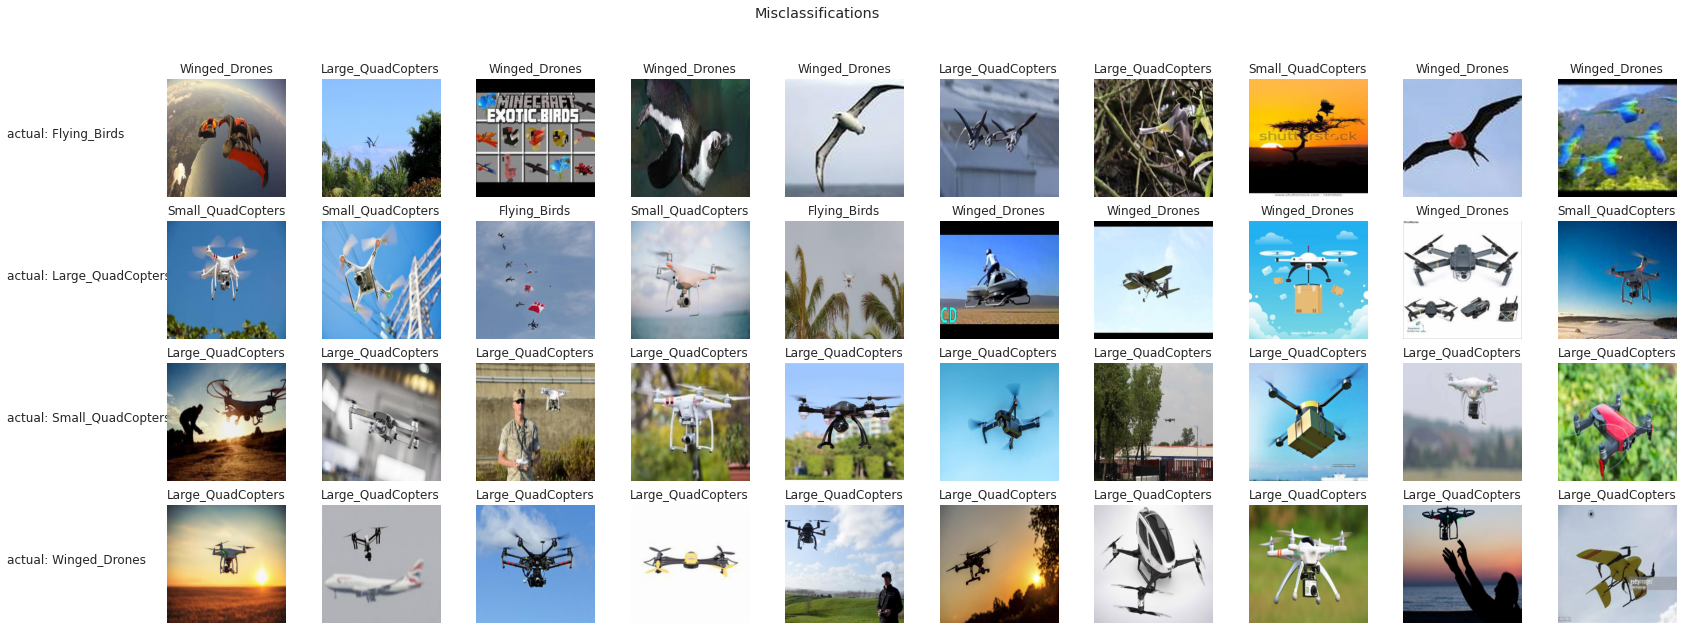

In [ ]:
plot_10misclassifications(miscla_10)

In [ ]:
def get_classifications(model, test_loader, device):
    classified_target = []
    classified_pred = []

    model = model.to(device)

    # set the model to evaluation mode
    model.eval()

    # turn off gradients
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            # move them to respective device
            data, target = data.to(device), target.to(device)

            # do inferencing
            output = model(data)

            # get the predicted output
            pred = output.argmax(dim=1, keepdim=True)

            batch_pred = pred
            batch_target = target

            classified_pred.append(batch_pred)
            classified_target.append(batch_target)

    # group all the batched together

    classified_pred = torch.cat(classified_pred)
    classified_target = torch.cat(classified_target)

    return classified_pred, classified_target

In [ ]:
classifications = get_classifications(model, test_loader, device)

In [ ]:
preds, actuals = classifications

In [ ]:
actuals_np = actuals.cpu().numpy()

In [ ]:
preds_np = preds.squeeze(1).cpu().numpy()

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix
def show_accuracy_report(actuals, predictions, classes):
    # print(len(actuals),len(predictions))
    print(classification_report(actuals, 
                                predictions,
                                target_names=classes))
    cm = confusion_matrix(actuals,predictions)
    cm = pd.DataFrame(cm , index = classes , columns = classes)
    print(cm)
    plt.figure(figsize = (8, 6))
    labels = classes
    sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

                   precision    recall  f1-score   support

     Flying_Birds       0.96      0.99      0.98      2449
Large_QuadCopters       0.58      0.91      0.71      1466
Small_QuadCopters       0.84      0.31      0.45      1084
    Winged_Drones       0.94      0.80      0.87      1659

         accuracy                           0.82      6658
        macro avg       0.83      0.75      0.75      6658
     weighted avg       0.85      0.82      0.80      6658

                   Flying_Birds  ...  Winged_Drones
Flying_Birds               2431  ...             12
Large_QuadCopters            29  ...             50
Small_QuadCopters            12  ...             24
Winged_Drones                59  ...           1335

[4 rows x 4 columns]


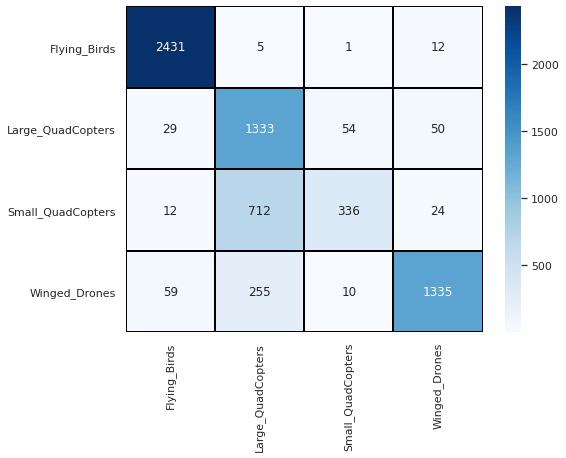

In [ ]:
show_accuracy_report(actuals_np, preds_np, IFODataset.class_names)